In [7]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Extracting CLIP Image features
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

In [9]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Complete_1Yr_1.5T_12_20_2024.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 12)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,12/07/2024
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,12/07/2024
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,12/07/2024
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,12/07/2024
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,12/07/2024


In [18]:
import pandas as pd
import numpy as np
import torch
import clip

# Load CSV
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Complete_1Yr_1.5T_12_20_2024.csv")

# 🔹 Step 1: Keep label and encode it numerically
label_map = {'AD': 0, 'CN': 1, 'MCI': 2}
df = df[df['Group'].isin(label_map)]  # filter out unknowns
df['label'] = df['Group'].map(label_map)

# 🔹 Step 2: Prepare text input (excluding label columns)
text_input_cols = [col for col in df.columns if col not in ['Group', 'label', 'Downloaded', 'Modality', 'Type', 'Format']]
df_text = df[text_input_cols]

# 🔹 Optional: Keep Image IDs if you want to track
image_ids = df['Image Data ID'].values

# 🔹 Step 3: Combine row text into string per patient
texts = df_text.astype(str).agg(" ".join, axis=1).tolist()

# 🔹 Step 4: Tokenize with CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
text_tokens = clip.tokenize(texts).to(device)

# 🔹 Step 5: Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()

# 🔹 Step 6: Save embeddings and labels (ready for training!)
np.save("train_text_features_only.npy", text_embeddings)
np.save("train_text_labels_only.npy", df['label'].values)

# Optional: save a CSV for review
df_out = pd.DataFrame(text_embeddings)
df_out['label'] = df['label'].values
df_out.to_csv("train_text_features_with_labels.csv", index=False)

print("Saved:")
print(" - train_text_features_only.npy", text_embeddings.shape)
print(" - train_text_labels_only.npy", df['label'].shape)

Saved:
 - train_text_features_only.npy (2294, 512)
 - train_text_labels_only.npy (2294,)


In [19]:
df = pd.read_csv("train_text_features_with_labels.csv")

# Preview the first few rows
print(df.shape)
df.head()

print("Final dataframe shape:", df.shape)
print("All column names:", df.columns.tolist())

(2294, 513)
Final dataframe shape: (2294, 513)
All column names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '

CHECK FOR DATA OVERLAPPING

In [20]:
import numpy as np
import os

# Load original image paths
train_paths = np.load("train_image_paths_axial.npy", allow_pickle=True)
val_paths = np.load("val_image_paths_axial.npy", allow_pickle=True)
test_paths = np.load("test_image_paths_axial.npy", allow_pickle=True)

# Extract image IDs (e.g., "I12345_AD_axial_55.png" → "I12345")
def extract_ids(paths):
    return set(os.path.basename(p).split("_")[0] for p in paths)

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)
test_ids = extract_ids(test_paths)

# 1. Check for overlaps between splits
overlap_train_val = train_ids & val_ids
overlap_train_test = train_ids & test_ids
overlap_val_test = val_ids & test_ids

# Print results
print("🔍 Checking for ID overlaps between splits:")
print("Train ∩ Val:", len(overlap_train_val))
print("Train ∩ Test:", len(overlap_train_test))
print("Val ∩ Test:", len(overlap_val_test))

# 2. (Optional) Also check if any text_image_ids are used in multiple splits
text_ids = np.load("text_image_ids.npy", allow_pickle=True)
text_ids_set = set(text_ids)

text_in_train = text_ids_set & train_ids
text_in_val = text_ids_set & val_ids
text_in_test = text_ids_set & test_ids

print("\n📦 Text sample distribution:")
print("Text IDs in Train:", len(text_in_train))
print("Text IDs in Val:", len(text_in_val))
print("Text IDs in Test:", len(text_in_test))

# Sanity check for overlaps in textual split
print("\n🔁 Overlap in Textual Data:")
print("Text Train ∩ Val:", len(text_in_train & text_in_val))
print("Text Train ∩ Test:", len(text_in_train & text_in_test))
print("Text Val ∩ Test:", len(text_in_val & text_in_test))

🔍 Checking for ID overlaps between splits:
Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0

📦 Text sample distribution:
Text IDs in Train: 1541
Text IDs in Val: 153
Text IDs in Test: 226

🔁 Overlap in Textual Data:
Text Train ∩ Val: 0
Text Train ∩ Test: 0
Text Val ∩ Test: 0


In [22]:
import torch.nn as nn

# --------------------- Define MLP Model ---------------------
class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3)  # 3 classes: AD, CN, MCI
        )

    def forward(self, x):
        return self.net(x)


In [24]:
import os

# Load the image split path files
train_paths = np.load("train_image_paths_axial.npy", allow_pickle=True)
val_paths = np.load("val_image_paths_axial.npy", allow_pickle=True)
test_paths = np.load("test_image_paths_axial.npy", allow_pickle=True)

def extract_ids(paths):
    return set(os.path.basename(p).split("_")[0] for p in paths)

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)
test_ids = extract_ids(test_paths)

In [25]:
# Load your text embeddings and image IDs:

text_embeddings = np.load("train_text_features_only.npy")
text_labels = np.load("train_text_labels_only.npy")
text_ids = np.load("text_image_ids.npy", allow_pickle=True)  # assuming you saved these earlier
text_ids = df['Image Data ID'].values

In [26]:
# Now match and split

train_feats, val_feats, test_feats = [], [], []
train_labs, val_labs, test_labs = [], [], []

for emb, label, tid in zip(text_embeddings, text_labels, text_ids):
    tid_str = str(tid)
    if tid_str in train_ids:
        train_feats.append(emb)
        train_labs.append(label)
    elif tid_str in val_ids:
        val_feats.append(emb)
        val_labs.append(label)
    elif tid_str in test_ids:
        test_feats.append(emb)
        test_labs.append(label)

In [27]:
# Convert and save if needed (for cross-checking

train_feats, val_feats, test_feats = map(np.array, [train_feats, val_feats, test_feats])
train_labs, val_labs, test_labs = map(np.array, [train_labs, val_labs, test_labs])

np.save("text_train_features.npy", train_feats)
np.save("text_train_labels.npy", train_labs)

np.save("text_val_features.npy", val_feats)
np.save("text_val_labels.npy", val_labs)

np.save("text_test_features.npy", test_feats)
np.save("text_test_labels.npy", test_labs)

print("Train:", train_feats.shape)
print("Val:", val_feats.shape)
print("Test:", test_feats.shape)

Train: (1541, 512)
Val: (153, 512)
Test: (226, 512)


Epoch 1/100, Train Loss: 1.0985, Val Loss: 1.1020
Epoch 2/100, Train Loss: 1.0889, Val Loss: 1.0956
Epoch 3/100, Train Loss: 1.0761, Val Loss: 1.0927
Epoch 4/100, Train Loss: 1.0680, Val Loss: 1.0909
Epoch 5/100, Train Loss: 1.0565, Val Loss: 1.0856
Epoch 6/100, Train Loss: 1.0487, Val Loss: 1.0812
Epoch 7/100, Train Loss: 1.0415, Val Loss: 1.0786
Epoch 8/100, Train Loss: 1.0282, Val Loss: 1.0819
Epoch 9/100, Train Loss: 1.0237, Val Loss: 1.0820
Epoch 10/100, Train Loss: 1.0147, Val Loss: 1.0775
Epoch 11/100, Train Loss: 1.0027, Val Loss: 1.0696
Epoch 12/100, Train Loss: 0.9923, Val Loss: 1.0682
Epoch 13/100, Train Loss: 0.9784, Val Loss: 1.0703
Epoch 14/100, Train Loss: 0.9693, Val Loss: 1.0615
Epoch 15/100, Train Loss: 0.9592, Val Loss: 1.0634
Epoch 16/100, Train Loss: 0.9437, Val Loss: 1.0571
Epoch 17/100, Train Loss: 0.9318, Val Loss: 1.0521
Epoch 18/100, Train Loss: 0.9219, Val Loss: 1.0496
Epoch 19/100, Train Loss: 0.9065, Val Loss: 1.0490
Epoch 20/100, Train Loss: 0.8947, Val Lo

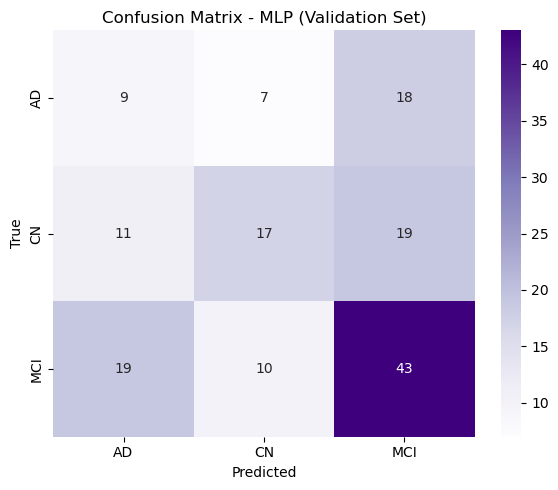

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import gc

# --------------------- Load Data ---------------------
X_train = np.load("text_train_features.npy")
y_train = np.load("text_train_labels.npy")

X_val = np.load("text_val_features.npy")
y_val = np.load("text_val_labels.npy")

# --------------------- Normalize ---------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# --------------------- SMOTE Oversampling ---------------------
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# --------------------- Tensor Conversion ---------------------
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


# --------------------- Training Setup ---------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100


best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5  # You can tune this
early_stop = False

best_model_state = None  # To save the best model
# --------------------- Train Loop ---------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # ---------------- Validate ----------------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Check --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⛔ Early stopping at epoch {epoch+1}")
            early_stop = True
            break
gc.collect()
torch.cuda.empty_cache()

# --------------------- Evaluate on Training Set ---------------------
model.eval()
y_train_preds = []
y_train_true = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

train_acc = accuracy_score(y_train_true, y_train_preds)
print(f"📊 Training Accuracy: {train_acc:.4f}")

# --------------------- Evaluate on Validation Set ---------------------
y_val_preds = []
y_val_true = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_val_preds.extend(preds.cpu().numpy())
        y_val_true.extend(yb.numpy())

val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD", "CN", "MCI"]))

# --------------------- Confusion Matrix ---------------------
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_test and y_pred are already defined from your previous evaluation

# Define class labels (you can update these if your label encoding is different)
class_names = ['AD', 'CN', 'MCI']

# Accuracy
accuracy = accuracy_score(y_val_true, y_val_preds)
print(f"\n Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print("\n Classification Report:")
print(classification_report(y_val_true, y_val_preds, target_names=class_names))



 Accuracy: 0.4510

 Classification Report:
              precision    recall  f1-score   support

          AD       0.23      0.26      0.25        34
          CN       0.50      0.36      0.42        47
         MCI       0.54      0.60      0.57        72

    accuracy                           0.45       153
   macro avg       0.42      0.41      0.41       153
weighted avg       0.46      0.45      0.45       153



	.   ✅ Replace np.concatenate() fusion with a trainable layer
	•	✅ Try BioCLIP or medical image-pretrained models
	•	✅ Improve tabular/text embedding via BioBERT or using key columns only
	•	✅ Regularize fusion with modality dropout
	•	✅ (Optional) Try late fusion/ensemble as a baseline